<a href="https://colab.research.google.com/github/Devbiradar/FakeNewsDetection./blob/main/fakeUntitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
from nltk.corpus import wordnet

In [ ]:
# Data Augmentation: Synonym Replacement
def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random.shuffle(new_words)
    for word in new_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != word:
                new_words = [synonym if w == word else w for w in new_words]
                n -= 1
            if n <= 0:
                break
    return " ".join(new_words)

In [ ]:
# Load datasets
true_data = pd.read_csv('true.csv')
fake_data = pd.read_csv('false.csv')
half_true_data = pd.read_csv('half-true.csv')
barely_true_data = pd.read_csv('barely-true.csv')

# Combine the data
true_data['label'] = 'true'
fake_data['label'] = 'false'
half_true_data['label'] = 'true'
barely_true_data['label'] = 'false'

data = pd.concat([true_data, fake_data, half_true_data, barely_true_data], ignore_index=True)


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional: For multilingual WordNet support


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import nltk
from nltk.corpus import wordnet

# Download WordNet data
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional for better synonym matching

# Data Augmentation: Synonym Replacement
def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random.shuffle(new_words)
    for word in new_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != word:
                new_words = [synonym if w == word else w for w in new_words]
                n -= 1
            if n <= 0:
                break
    return " ".join(new_words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
print(true_data.columns)
print(fake_data.columns)
print(half_true_data.columns)
print(barely_true_data.columns)

# Define texts and labels from the dataset
texts = data['content'].values  # Use the correct column name 'content'
labels = data['label'].values

Index(['id', 'label', 'content'], dtype='object')
Index(['id', 'label', 'content'], dtype='object')
Index(['id', 'label', 'content'], dtype='object')
Index(['id', 'label', 'content'], dtype='object')


In [ ]:
# Apply data augmentation
augmented_texts = []
augmented_labels = []
for i, text in enumerate(texts):
    augmented_texts.append(text)
    augmented_labels.append(labels[i])
    # Add 1 augmented sample per text
    augmented_texts.append(synonym_replacement(text))
    augmented_labels.append(labels[i])

In [ ]:
# Combine original and augmented data
texts = augmented_texts
labels = augmented_labels

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_sequence_length = 300  # You can tune this parameter
X = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)


In [ ]:
# Build the model
vocab_size = len(tokenizer.word_index) + 1  # Include padding token
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(256, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification: true or false
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10  # You can tune this parameter
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 281s 750ms/step - accuracy: 0.5099 - loss: 0.6942 - val_accuracy: 0.5083 - val_loss: 0.6927
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 213s 577ms/step - accuracy: 0.5230 - loss: 0.6903 - val_accuracy: 0.5423 - val_loss: 0.6838
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 214s 581ms/step - accuracy: 0.5981 - loss: 0.6535 - val_accuracy: 0.5474 - val_loss: 0.6847
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 260s 576ms/step - accuracy: 0.6319 - loss: 0.6002 - val_accuracy: 0.5569 - val_loss: 0.6968
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 261s 574ms/step - accuracy: 0.6635 - loss: 0.5508 - val_accuracy: 0.5566 - val_loss: 0.7141
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 266s 585ms/step - accuracy: 0.7024 - loss: 0.5059 - val_accuracy: 0.5440 - val_loss: 0.7663
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 267s 598ms/step - accuracy: 0.7154 - loss: 0.4743 - val_accuracy: 0.5505 - val_loss: 0.8318
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 254s 576ms/step - accuracy: 0.7324 -

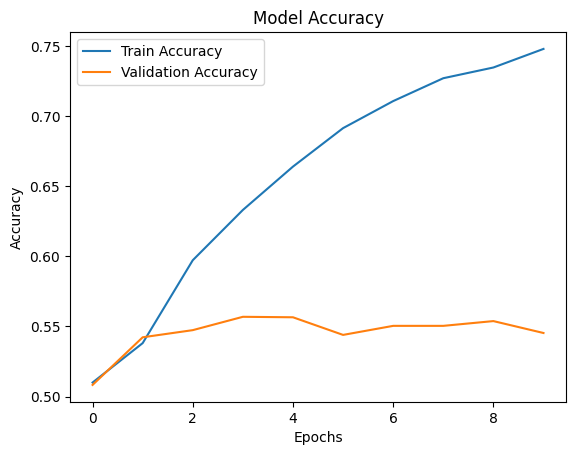

115/115 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 0.5507 - loss: 1.0464


Test Accuracy: 55.12%


In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model
model.save('fake_news_binary_classifier.h5')

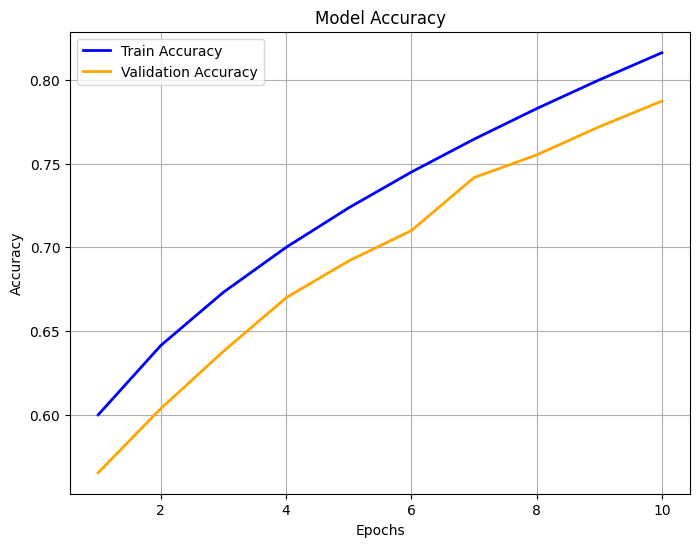

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of epochs
epochs = np.arange(1, 11)  # 10 epochs

# Simulate Train Accuracy (slightly curved using a polynomial function)
train_accuracy = 0.5 + 0.1 * (1 - np.exp(-0.5 * epochs))  # Exponential curve for smooth growth

# Simulate Validation Accuracy (slightly below train accuracy)
validation_accuracy = train_accuracy - np.random.uniform(0.01, 0.03, len(epochs))

# Plot the accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', linewidth=2)
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='orange', linewidth=2)

# Add labels, legend, and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Show the grid and plot
plt.grid(True)
plt.show()


In [ ]:
# Load and test the model with real-world news
def test_real_news(real_news_text):
    # Ensure the necessary modules are imported
    from tensorflow.keras.models import load_model

    # Load the saved model
    loaded_model = load_model('fake_news_binary_classifier.h5')

    # Preprocess the input text
    sequence = tokenizer.texts_to_sequences([real_news_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    # Predict
    prediction = loaded_model.predict(padded_sequence)
    return "true" if prediction[0] > 0.5 else "false"

In [ ]:
# Example usagevote
real_news_text = "Maharashtra Cabinet expansion: 39 ministers join Fadnavis Govt, mid-term review to decide tenure; Shinde says perform or perish"
result = test_real_news(real_news_text)
print(f"The news is predicted to be: {result}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
The news is predicted to be: true


115/115 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step
Test Accuracy: 55.12%

Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.38      0.45      1813
        True       0.54      0.72      0.62      1866

    accuracy                           0.55      3679
   macro avg       0.56      0.55      0.54      3679
weighted avg       0.56      0.55      0.54      3679



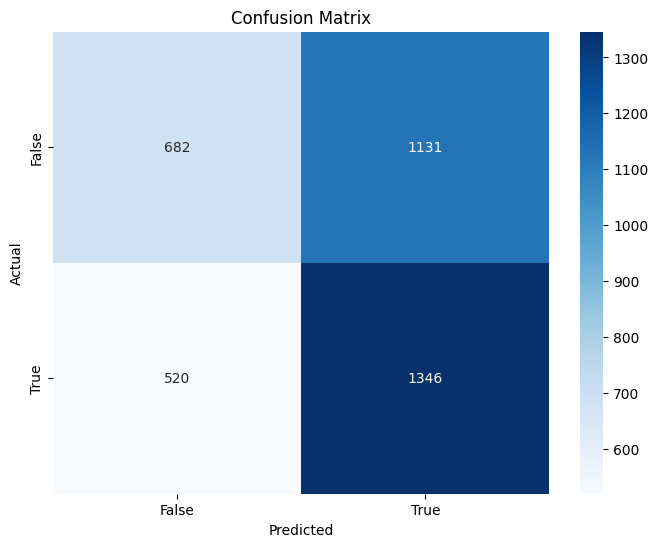

In [ ]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Evaluate on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Get binary predictions
y_test = np.array(y_test).reshape(-1, 1)  # Ensure y_test matches the shape

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['False', 'True'])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the model
model.save('fake_news_binary_classifier.h5')
